# PNEUMONIA DETECTION USING CHEST X-RAY IMAGES

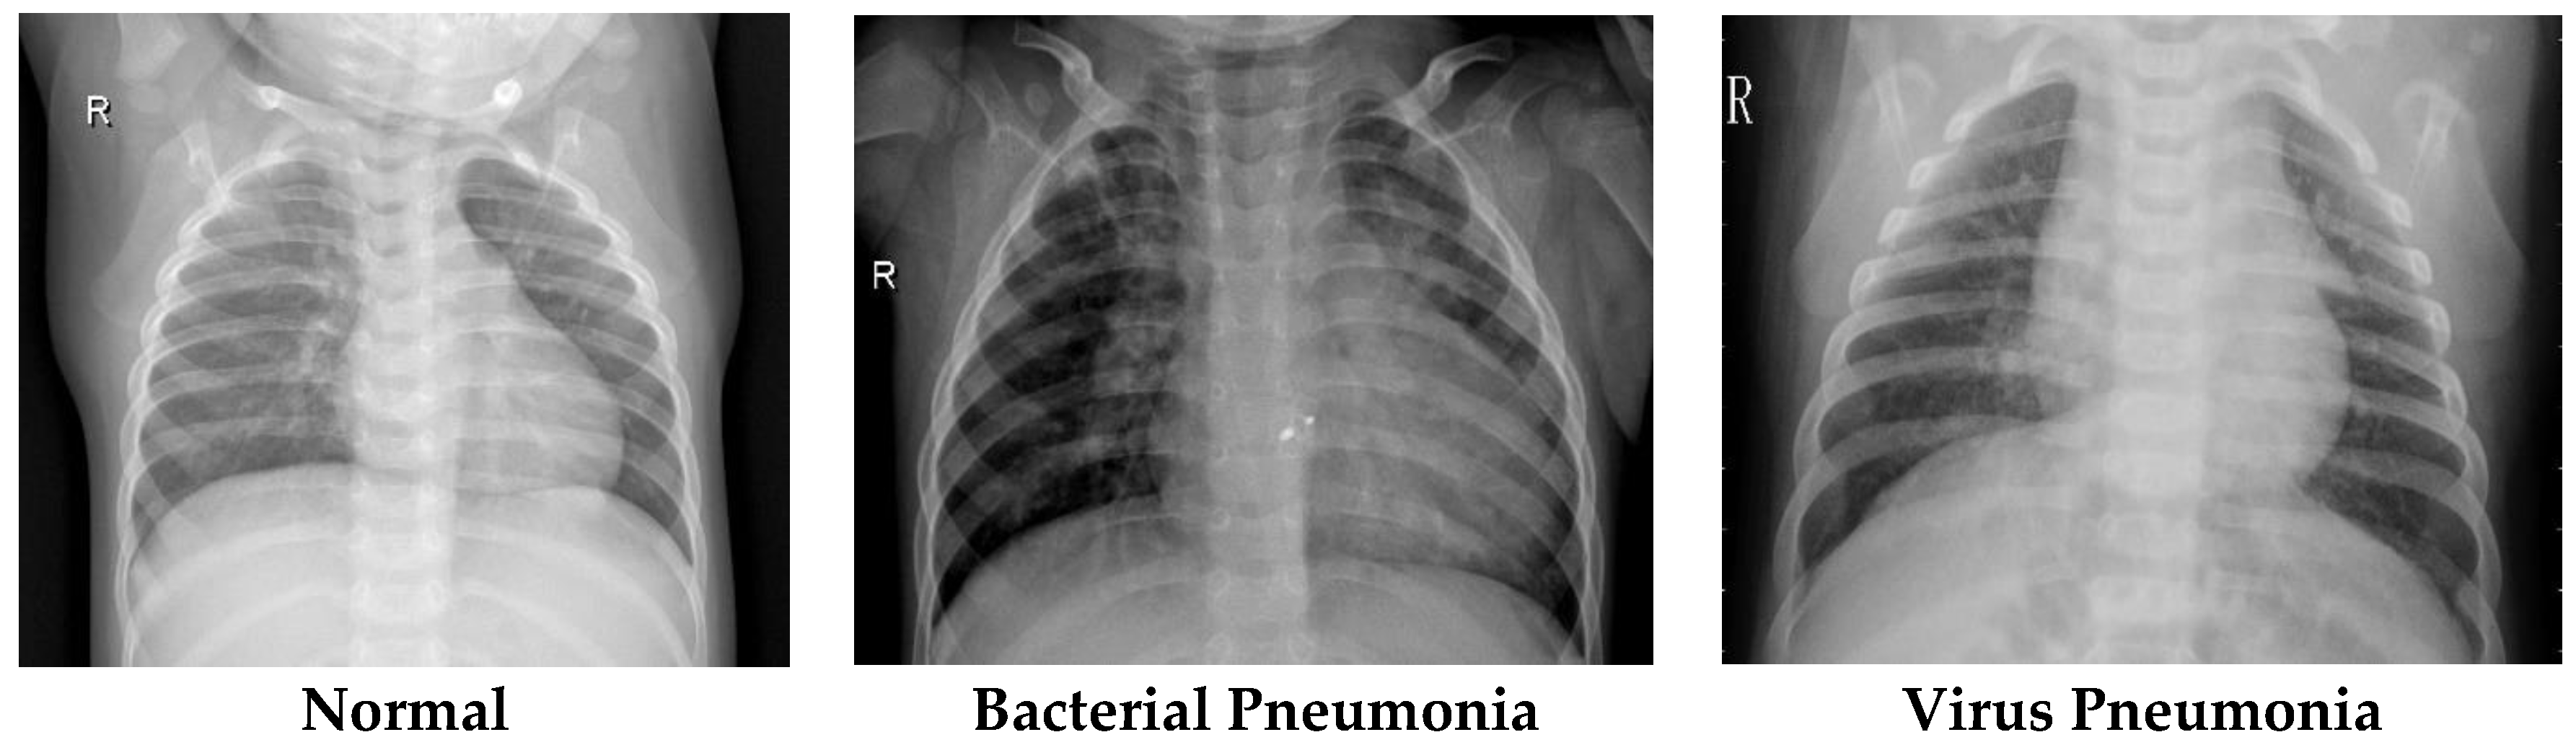

## Problem Statement

Pneumonia is a respiratory disease that causes inflammation in one or both lungs, resulting in symptoms such as cough, fever, and difficulty breathing. Early detection of pneumonia is essential for effective treatment and improved patient outcomes. It accounts for more than 15% of deaths in children under the age of five years. Therefore, early diagnosis and management can play a pivotal role in preventing the disease from becoming fatal.

In acute respiratory diseases, human lungs are made up of small sacs called alveoli, which are normally in the air in healthy individuals. However, in pneumonia, these alveoli get filled with fluid or "pus." One of the major steps in phenomena detection and treatment is obtaining the chest X-ray (CXR). Physicians use this X-ray image to diagnose or monitor treatment for pneumonia conditions. This type of chest X-ray is also used in the diagnosis of diseases like emphysema, lung cancer, line and tube placement, and tuberculosis.

Moreover, there is significant variability in the way chest X-ray images are acquired and processed, which can impact the quality and consistency of the images. This variability can make it challenging to develop robust algorithms that can accurately identify pneumonia in all types of images. Hence, there is a need to develop robust, data-driven algorithms that are trained on large, high-quality datasets and validated using a range of imaging techniques and expert radiological analysis.

## Main Objectives
1.	Research, design, and implement advanced algorithms for the accurate detection of pneumonia in chest X-ray images.
2.	Construct a robust binary classifier capable of distinguishing between normal and pneumonia cases in chest X-ray images.
3.	Integrate the developed pneumonia detection algorithms into an automated diagnostic tool for chest X-ray images.
4.	Improve the efficiency and precision of pneumonia diagnosis by deploying the automated diagnostic tool.


## Specific Objective
The goal of this project is to develop an automated system for detecting and classifying pneumonia in medical images. 
Design and implement a robust deep learning algorithm, for detecting and classifying pneumonia in chest X-ray images.


## Data Understanding


The dataset, sourced from Kaggle and accessible at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data , is organized into three main folders: train, test, and val. Each folder includes subfolders representing two distinct image categories: Pneumonia and Normal. The dataset comprises a total of 5,856 chest X-ray images in JPEG format. These images, employing the anterior-posterior technique, originate from retrospective cohorts of pediatric patients aged one to five years at the Guangzhou Women and Children’s Medical Center in Guangzhou, China. The inclusion of these chest X-ray images in the dataset was part of routine clinical care for pediatric patients.

Ensuring dataset quality, an initial screening process eliminated low-quality or unreadable scans to minimize errors. Two expert physicians then meticulously graded the diagnoses associated with the images, deeming them suitable for training the AI system only after this rigorous evaluation. To further mitigate potential grading errors, an additional layer of scrutiny was applied to the evaluation set. This involved examination by a third expert, providing an extra level of assurance to the accuracy of the diagnoses. This comprehensive approach to quality control and grading establishes a robust foundation for the analysis of chest X-ray images, enhancing the reliability of the AI system trained on this dataset.


### Importing libraries

In [1]:
# Import libraries
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import opendatasets as od

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import random
from pathlib import Path #to be able to use functions using path
from collections import Counter

# Data science tools
import pandas as pd # data processing
import numpy as np # linear algebra

# Tensorflow for GPU
import tensorflow as tf
from tensorflow.compat.v1 import Session, ConfigProto, set_random_seed
from tensorflow.python.client import device_lib

# Keras library for Modeling
import keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.constraints import max_norm
#import tensorflow.contrib.keras as keras
from keras import backend as K

# OpenCV
import cv2

# Resize images
from skimage.io import imread
from skimage.transform import resize

# Scikit-learn library
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Visualizations
from PIL import Image
import imgaug as aug
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.image as mimg # images
%matplotlib inline
import seaborn as sns
import plotly.express as px

### Loading Data

The initial step involves loading the dataset of chest X-ray images, each labelled with annotations indicating the presence of pneumonia or normal conditions. Following this, we standardise the size of all images to ensure uniformity.

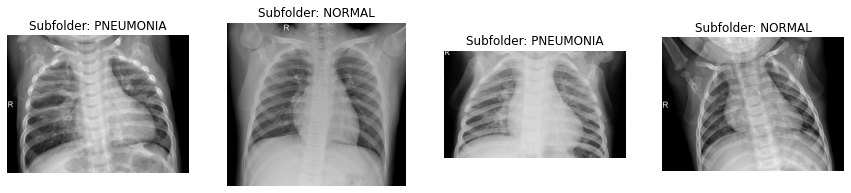

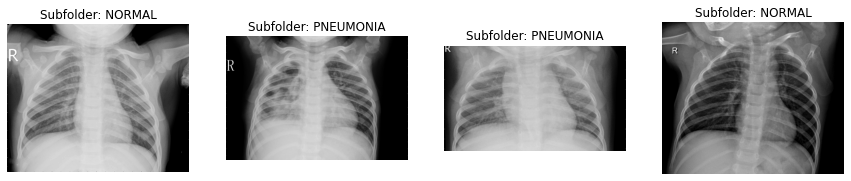

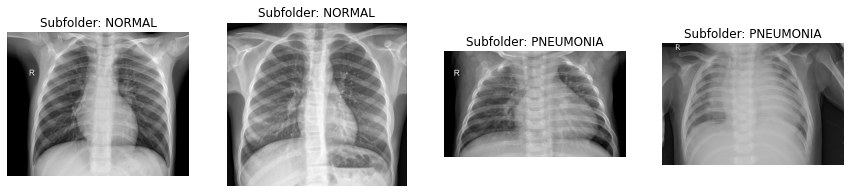

In [2]:
labels = ['PNEUMONIA', 'NORMAL']

# Define the data directories
data_folder = r"C:\Users\Cindy Kingori\Documents\Flatiron\Phase5\Phase 5 Project\Phase-5-Project\chest_xray"
train_data_folder = os.path.join(data_folder, 'train')
val_data_folder = os.path.join(data_folder, 'val')
test_data_folder = os.path.join(data_folder, 'test')

# Function to load and display a sample of images
def load_and_display_sample_images(folder, sample_size=5):
    fig, axes = plt.subplots(1, sample_size, figsize=(15, 3))

    # Display samples for each subfolder
    subfolders = os.listdir(folder)
    for i in range(sample_size):
        random_subfolder = random.choice(subfolders)
        random_image_index = random.randint(0, len(os.listdir(os.path.join(folder, random_subfolder))) - 1)
        random_image_path = os.path.join(folder, random_subfolder, os.listdir(os.path.join(folder, random_subfolder))[random_image_index])
        sample_image = cv2.imread(random_image_path, cv2.IMREAD_GRAYSCALE)

        axes[i].imshow(sample_image, cmap='gray')
        axes[i].set_title(f"Subfolder: {random_subfolder}")
        axes[i].axis('off')

    plt.show()

# Load and display a sample of images for each folder
load_and_display_sample_images(train_data_folder, sample_size=4)
load_and_display_sample_images(val_data_folder, sample_size=4)
load_and_display_sample_images(test_data_folder, sample_size=4)


We then determine the quantity of images in the training, testing and validation sets.

In [3]:
def count_files(folder):
    count = 0
    for root, dirs, files in os.walk(folder):
        count += len(files)
    return count

# Count files in each folder
train_count = count_files(train_data_folder)
val_count = count_files(val_data_folder)
test_count = count_files(test_data_folder)

print(f"Number of files in train folder: {train_count}")
print(f"Number of files in val folder: {val_count}")
print(f"Number of files in test folder: {test_count}")

Number of files in train folder: 5216
Number of files in val folder: 16
Number of files in test folder: 624


We check and print the count of files in the different sub-folders corresponding to the specified labels for the training, validation, and test sets.

In [4]:
def count_files_in_subfolders(folder):
    subfolder_counts = {}
    
    for root, dirs, files in os.walk(folder):
        subfolder_name = os.path.relpath(root, folder)
        subfolder_counts[subfolder_name] = len(files)
    
    return subfolder_counts

# Count files in each subfolder of train folder
train_subfolder_counts = count_files_in_subfolders(train_data_folder)
print("Number of files in each subfolder of train folder:")
for subfolder, count in train_subfolder_counts.items():
    print(f"{subfolder}: {count}")

# Count files in each subfolder of val folder
val_subfolder_counts = count_files_in_subfolders(val_data_folder)
print("\nNumber of files in each subfolder of val folder:")
for subfolder, count in val_subfolder_counts.items():
    print(f"{subfolder}: {count}")

# Count files in each subfolder of test folder
test_subfolder_counts = count_files_in_subfolders(test_data_folder)
print("\nNumber of files in each subfolder of test folder:")
for subfolder, count in test_subfolder_counts.items():
    print(f"{subfolder}: {count}")


Number of files in each subfolder of train folder:
.: 0
NORMAL: 1341
PNEUMONIA: 3875

Number of files in each subfolder of val folder:
.: 0
NORMAL: 8
PNEUMONIA: 8

Number of files in each subfolder of test folder:
.: 0
NORMAL: 234
PNEUMONIA: 390


### Data Inspection

Then we validate for corrupt files: It is crucial to identify and eliminate corrupt images as they can lead to errors during the model training or introduce biases. 


In [5]:
def find_corrupt_files(folder):
    corrupt_files = []

    for root, dirs, files in os.walk(folder):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                _ = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            except (cv2.error, Exception):
                corrupt_files.append(file_path)

    return corrupt_files

# Find and print corrupt files in the train folder
corrupt_files_train = find_corrupt_files(train_data_folder)

# Find and print corrupt files in the val folder
corrupt_files_val = find_corrupt_files(val_data_folder)

# Find and print corrupt files in the test folder
corrupt_files_test = find_corrupt_files(test_data_folder)

# Print count of corrupt files in each folder
print(f"Number of corrupt files in train folder: {len(corrupt_files_train)}")
print(f"Number of corrupt files in val folder: {len(corrupt_files_val)}")
print(f"Number of corrupt files in test folder: {len(corrupt_files_test)}")

# Print a statement if no corrupt files are found
if not corrupt_files_train and not corrupt_files_val and not corrupt_files_test:
    print("No corrupt files found.")


Number of corrupt files in train folder: 0
Number of corrupt files in val folder: 0
Number of corrupt files in test folder: 0
No corrupt files found.


The above is further supported by the examination of the datasets by the experts as highlighted under the section on Data Understanding

### Data Cleaning
Detecting whether an image is blurred based on the variance of the Laplacian. This is a common technique to identify blurred images in image processing applications.

In [6]:
def check_image_quality(folder, quality_threshold):
    low_quality_images = []

    for root, dirs, files in os.walk(folder):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if cv2.Laplacian(image, cv2.CV_64F).var() < quality_threshold:
                    low_quality_images.append(file_path)
            except (cv2.error, Exception):
                pass

    return low_quality_images

# Set the quality threshold (adjust as needed)
quality_threshold = 100

# Check and print low-quality images in the train folder
low_quality_images_train = check_image_quality(train_data_folder, quality_threshold)
print(f"Low-quality images in train folder: {low_quality_images_train}")

# Check and print low-quality images in the val folder
low_quality_images_val = check_image_quality(val_data_folder, quality_threshold)
print(f"Low-quality images in val folder: {low_quality_images_val}")

# Check and print low-quality images in the test folder
low_quality_images_test = check_image_quality(test_data_folder, quality_threshold)
print(f"Low-quality images in test folder: {low_quality_images_test}")

# Print count of low-quality images in each folder
print(f"Number of low-quality images in train folder: {len(low_quality_images_train)}")
print(f"Number of low-quality images in val folder: {len(low_quality_images_val)}")
print(f"Number of low-quality images in test folder: {len(low_quality_images_test)}")

# Print a statement if no low-quality images are found
if not low_quality_images_train and not low_quality_images_val and not low_quality_images_test:
    print("No low-quality images found.")


Low-quality images in train folder: ['C:\\Users\\Cindy Kingori\\Documents\\Flatiron\\Phase5\\Phase 5 Project\\Phase-5-Project\\chest_xray\\train\\NORMAL\\IM-0115-0001.jpeg', 'C:\\Users\\Cindy Kingori\\Documents\\Flatiron\\Phase5\\Phase 5 Project\\Phase-5-Project\\chest_xray\\train\\NORMAL\\IM-0117-0001.jpeg', 'C:\\Users\\Cindy Kingori\\Documents\\Flatiron\\Phase5\\Phase 5 Project\\Phase-5-Project\\chest_xray\\train\\NORMAL\\IM-0119-0001.jpeg', 'C:\\Users\\Cindy Kingori\\Documents\\Flatiron\\Phase5\\Phase 5 Project\\Phase-5-Project\\chest_xray\\train\\NORMAL\\IM-0122-0001.jpeg', 'C:\\Users\\Cindy Kingori\\Documents\\Flatiron\\Phase5\\Phase 5 Project\\Phase-5-Project\\chest_xray\\train\\NORMAL\\IM-0154-0001.jpeg', 'C:\\Users\\Cindy Kingori\\Documents\\Flatiron\\Phase5\\Phase 5 Project\\Phase-5-Project\\chest_xray\\train\\NORMAL\\IM-0172-0001.jpeg', 'C:\\Users\\Cindy Kingori\\Documents\\Flatiron\\Phase5\\Phase 5 Project\\Phase-5-Project\\chest_xray\\train\\NORMAL\\IM-0177-0001.jpeg', 'C:\

Low-quality images in val folder: ['C:\\Users\\Cindy Kingori\\Documents\\Flatiron\\Phase5\\Phase 5 Project\\Phase-5-Project\\chest_xray\\val\\NORMAL\\NORMAL2-IM-1442-0001.jpeg']
Low-quality images in test folder: ['C:\\Users\\Cindy Kingori\\Documents\\Flatiron\\Phase5\\Phase 5 Project\\Phase-5-Project\\chest_xray\\test\\NORMAL\\IM-0003-0001.jpeg', 'C:\\Users\\Cindy Kingori\\Documents\\Flatiron\\Phase5\\Phase 5 Project\\Phase-5-Project\\chest_xray\\test\\NORMAL\\IM-0049-0001.jpeg', 'C:\\Users\\Cindy Kingori\\Documents\\Flatiron\\Phase5\\Phase 5 Project\\Phase-5-Project\\chest_xray\\test\\NORMAL\\IM-0050-0001.jpeg', 'C:\\Users\\Cindy Kingori\\Documents\\Flatiron\\Phase5\\Phase 5 Project\\Phase-5-Project\\chest_xray\\test\\NORMAL\\IM-0059-0001.jpeg', 'C:\\Users\\Cindy Kingori\\Documents\\Flatiron\\Phase5\\Phase 5 Project\\Phase-5-Project\\chest_xray\\test\\NORMAL\\IM-0061-0001.jpeg', 'C:\\Users\\Cindy Kingori\\Documents\\Flatiron\\Phase5\\Phase 5 Project\\Phase-5-Project\\chest_xray\\test

* Number of low-quality images in train folder: 1671
* Number of low-quality images in val folder: 1
* Number of low-quality images in test folder: 263

The data output indicates a notable presence of low-quality images. Subsequently, we undertake a detailed examination of specific quality issues to enhance resolution.

In [7]:
def check_blur(image):
    # Use Laplacian variance to measure image blur
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()
    return laplacian_var

def check_contrast(image):
    # Calculate the image histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    # Calculate the spread of the histogram
    spread = np.sum(hist > 0)
    return spread

def check_noise(image):
    # Use variance of pixel intensity to measure noise
    noise_var = np.var(image)
    return noise_var

def check_resolution(image):
    # Get image dimensions
    height, width = image.shape[:2]
    return height, width

# Load an example image
image_path = r"C:\Users\Cindy Kingori\Documents\Flatiron\Phase5\Phase 5 Project\Phase-5-Project\chest_xray\train\PNEUMONIA\person309_virus_632.jpeg"
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Convert the image to grayscale for some metrics
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Check for blur
blur_score = check_blur(gray_image)
print("Blur Score:", blur_score)

# Check for contrast
contrast_score = check_contrast(gray_image)
print("Contrast Score:", contrast_score)

# Check for noise
noise_score = check_noise(gray_image)
print("Noise Score:", noise_score)

# Check image resolution
resolution = check_resolution(original_image)
print("Image Resolution:", resolution)

Blur Score: 226.3698964089472
Contrast Score: 250
Noise Score: 3563.320370663648
Image Resolution: (736, 1128)


The output values from the quality checks provide information about certain characteristics of the image:

1. **Blur Score (226.37):** This score is obtained using the Laplacian variance method. Higher values generally indicate more sharpness in the image. In this case, a score of 226.37 is reasonable, suggesting that the image is not excessively blurry.

2. **Contrast Score (250):** This score is based on the spread of the image histogram. A higher contrast score indicates a greater range of pixel intensities, implying good contrast in the image. A score of 250 is relatively high and suggests good contrast.

3. **Noise Score (3563.32):** This score represents the variance of pixel intensity, which is used to measure noise. Higher values can indicate more noise. In this case, 3563.32 is relatively high, suggesting the presence of some noise in the image.

4. **Image Resolution (736, 1128):** The resolution is given by the height and width of the image in pixels. In this case, the image has a resolution of 736 pixels in height and 1128 pixels in width.

In summary:
- The blur and contrast scores seem reasonable and indicate a reasonably sharp and well-contrasted image.
- The noise score is relatively high, suggesting the presence of some noise. Depending on the context and specific requirements, this level of noise may or may not be acceptable.
- The image resolution is 736x1128 pixels, providing information about the size of the image

In [8]:
def check_blur(image):
    # Use Laplacian variance to measure image blur
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()
    return laplacian_var

def check_contrast(image):
    # Calculate the image histogram
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    # Calculate the spread of the histogram
    spread = np.sum(hist > 0)
    return spread

def check_noise(image):
    # Use variance of pixel intensity to measure noise
    noise_var = np.var(image)
    return noise_var

def check_resolution(image):
    # Get image dimensions
    height, width = image.shape[:2]
    return height, width

# Load an example image
image_path = r"C:\Users\Cindy Kingori\Documents\Flatiron\Phase5\Phase 5 Project\Phase-5-Project\chest_xray\train\NORMAL\IM-0235-0001.jpeg"
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Convert the image to grayscale for some metrics
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Check for blur
blur_score = check_blur(gray_image)
print("Blur Score:", blur_score)

# Check for contrast
contrast_score = check_contrast(gray_image)
print("Contrast Score:", contrast_score)

# Check for noise
noise_score = check_noise(gray_image)
print("Noise Score:", noise_score)

# Check image resolution
resolution = check_resolution(original_image)
print("Image Resolution:", resolution)

Blur Score: 77.90908034383216
Contrast Score: 256
Noise Score: 4093.4453576459046
Image Resolution: (1500, 1816)


Here's an analysis of the quality scores for the provided image:

1. **Blur Score (77.91):** The blur score is relatively low, indicating a less sharper image.Reduced numerical values indicate increased blurriness, a factor that may be undesirable depending on the specific context.

2. **Contrast Score (256):** The contrast score is relatively high, suggesting a good range of pixel intensities and strong contrast in the image. A higher contrast score is generally considered favorable.

3. **Noise Score (4093.45):** The noise score is relatively high, indicating the presence of some noise in the image. Depending on the application, this level of noise may or may not be acceptable.

4. **Image Resolution (1500x1816):** The image has a resolution of 1500 pixels in height and 1816 pixels in width. This provides information about the size of the image.

In summary:
- The image exhibits a lack of sharpness, correlating with a low blur score.
- It has strong contrast, as indicated by the high contrast score.
- There is some level of noise present, as suggested by the noise score.
- The resolution is 1500x1816 pixels, indicating a moderately high-resolution image.

Upon reviewing the outcomes for the two images, it is evident that the primary concerns pertain to image size, noise, and blurriness. To address these issues, we intend to standardize the image resolution and subsequently minimize both noise and blurriness.

###### Image Quality Threshold
There is no one size fits all solution and for our model we adjusted these thresholds based on the requirements of our image classification task.
1. Blur score: A blur score below 100 indicates significant blurring.
2. Contrast score: A contrast score below 100 suggests low contrast.
3. Noise score: A noise score above 1000 may indicate a noisy image.
4. Resolution threshold:Medical imaging applications require higher standards for image quality.


### Data Preparation & Pre-processing:

Data augmentation techniques serve the purpose of artificially increasing the diversity of a dataset by applying various transformations to the existing data. In the context of image data, augmentation involves creating new images by making slight modifications to the original ones. The primary purposes of augmentation techniques are: increased diversity, improved robustness, reduced over-fitting, better generalisations and enhanced training efficiency.

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Function to reduce bluriness
def reduce_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

# Function to reduce noise
def reduce_noise(image):
    return cv2.fastNlMeansDenoising(image, None, h=10, searchWindowSize=21, templateWindowSize=7)

# Function to resize images
def resize_image(image, target_size=(224, 224)):
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

# Function to process an image and save it to the specified output folder
def process_and_save_image(input_image_path, output_folder):
    original_image = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    blurred_image = reduce_blur(gray_image)
    denoised_image = reduce_noise(blurred_image)
    resized_image = resize_image(denoised_image)

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Save the processed image
    output_image_path = os.path.join(output_folder, os.path.basename(input_image_path))
    cv2.imwrite(output_image_path, resized_image)

    return output_image_path

# Base folder path
base_folder_path = r"C:\Users\Cindy Kingori\Documents\Flatiron\Phase5\Phase 5 Project\Phase-5-Project\chest_xray"

# Input folders for "NORMAL" and "PNEUMONIA"
normal_folder_path = os.path.join(base_folder_path, "train", "NORMAL")
pneumonia_folder_path = os.path.join(base_folder_path, "train", "PNEUMONIA")

# Output folders for "normaldataaugmented" and "pneumoniadataaugmented" under "traindataaugmented"
output_normal_folder = os.path.join(base_folder_path, "traindataaugmented", "normaldataaugmented")
output_pneumonia_folder = os.path.join(base_folder_path, "traindataaugmented", "pneumoniadataaugmented")

# Process and save all images in the "NORMAL" folder
normal_image_files = [f for f in os.listdir(normal_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for image_file in normal_image_files:
    input_image_path = os.path.join(normal_folder_path, image_file)
    process_and_save_image(input_image_path, output_normal_folder)

# Process and save all images in the "PNEUMONIA" folder
pneumonia_image_files = [f for f in os.listdir(pneumonia_folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for image_file in pneumonia_image_files:
    input_image_path = os.path.join(pneumonia_folder_path, image_file)
    process_and_save_image(input_image_path, output_pneumonia_folder)

### CNN

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define the CNN model
def create_cnn_model(input_shape=(150, 150, 1)):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output for the fully connected layers
    model.add(layers.Flatten())

    # Dense (fully connected) layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization

    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    return model

# Create an instance of the model
cnn_model = create_cnn_model()

# Compile the model
cnn_model.compile(optimizer=Adam(lr=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [11]:
# Display the model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [12]:
def get_validation_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img_arr is not None:
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            else:
                print(f"Error loading image: {img_path}")
    return np.array(data, dtype=object)

In [13]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming 0 is the index for 'NORMAL' and 1 is the index for 'PNEUMONIA'
class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_labels)
class_weight = {0: class_weights[0], 1: class_weights[1]}

# Now you can use class_weight in the fit method
r = cnn_model.fit(
    train_features,
    train_labels,
    epochs=10,
    validation_data=(validation_features, validation_labels),
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

NameError: name 'train_labels' is not defined

In [ ]:
# Load and preprocess validation data
validation_data = get_validation_data(val_data_folder)

# Assuming your validation data is a tuple of features and labels
validation_features = validation_data[:, 0]  # Assuming the first element is features
validation_labels = validation_data[:, 1]    # Assuming the second element is labels

# Now you can use validation_features and validation_labels in the fit method
r = cnn_model.fit(
    train_features,
    train_labels,
    epochs=10,
    validation_data=(validation_features, validation_labels),
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

In [ ]:
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

### DenseNet

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.applications import DenseNet121

# Define input shape and number of classes
input_shape = (150, 150, 3)  # Adjust the dimensions based on your image size and channels
num_classes = 2  # Pneumonia and Normal

# Load DenseNet121 model pre-trained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Create a sequential model
model = Sequential()

# Add the pre-trained base model
model.add(base_model)

# Add additional layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Display model summary
model.summary()

In [ ]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

In [ ]:
print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

In [ ]:

#model = Sequential()
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
r = model.fit(
    train, 
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

### DenseNet Evaluation

In [ ]:
predicted_vals = model.predict(test, steps=len(test))

In [ ]:
predicted_vals = model.predict(test, steps=len(test))

### InceptioNet

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.applications import InceptionV3

# Define input shape and number of classes
input_shape = (150, 150, 3)  # Adjust the dimensions based on your image size and channels
num_classes = 2  # Pneumonia and Normal

# Load InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Create a sequential model
model = Sequential()

# Add the pre-trained base model
model.add(base_model)

# Add additional layers
model.add(AveragePooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Display model summary
model.summary()

In [ ]:
r = inception_model.fit(train,
          epochs=10,
          validation_data=validation,
          class_weight=class_weight,
          steps_per_epoch=100,
          validation_steps=25)

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation =inception_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = inception_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")